C:\Users\Sai\AppData\Local\Temp\ipykernel_23812\1921137656.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Displaying noisy image samples:


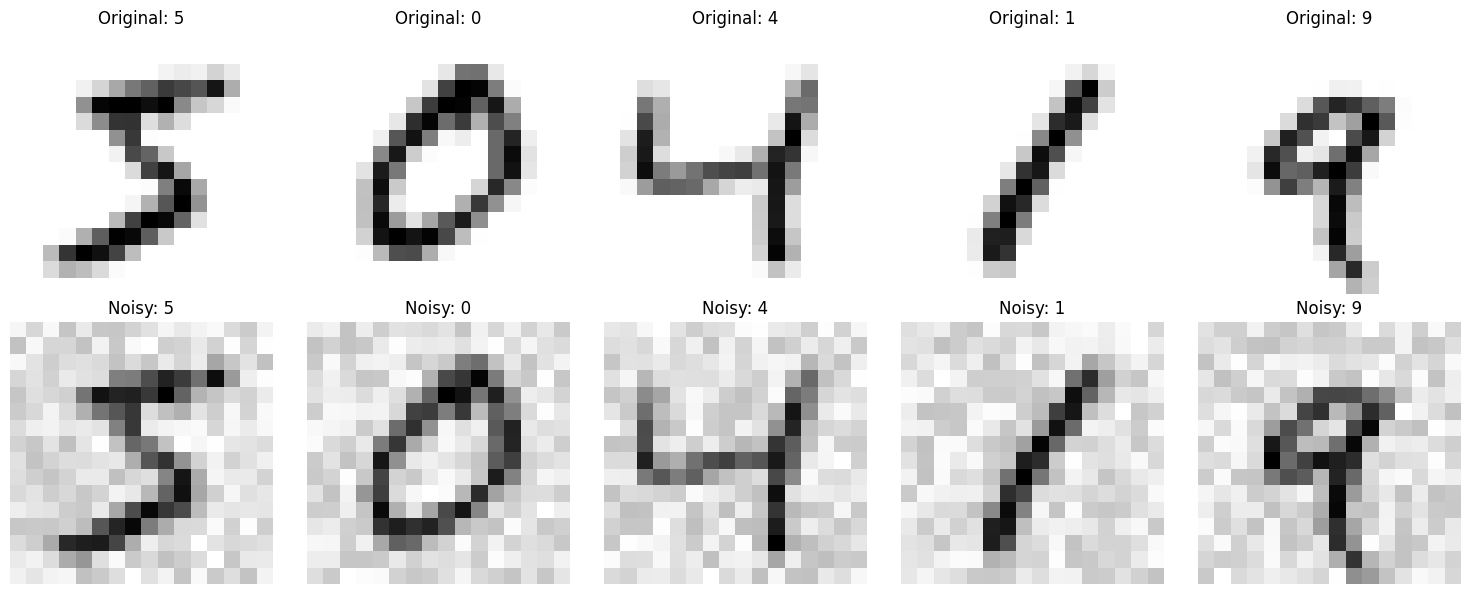

Epoch 1, Batch 100: Loss 0.181
Epoch 1, Batch 200: Loss 0.090
Epoch 1, Batch 300: Loss 0.101
Epoch 1, Batch 400: Loss 0.075
Epoch 1, Batch 500: Loss 0.075
Epoch 1, Batch 600: Loss 0.077
Epoch 1, Batch 700: Loss 0.076
Epoch 1, Batch 800: Loss 0.070
Epoch 1, Batch 900: Loss 0.058
Epoch 1 Test Accuracy: 98.82%
Epoch 2, Batch 100: Loss 0.053
Epoch 2, Batch 200: Loss 0.058
Epoch 2, Batch 300: Loss 0.051
Epoch 2, Batch 400: Loss 0.053
Epoch 2, Batch 500: Loss 0.044
Epoch 2, Batch 600: Loss 0.058
Epoch 2, Batch 700: Loss 0.045
Epoch 2, Batch 800: Loss 0.047
Epoch 2, Batch 900: Loss 0.047
Epoch 2 Test Accuracy: 98.78%
Epoch 3, Batch 100: Loss 0.045
Epoch 3, Batch 200: Loss 0.045
Epoch 3, Batch 300: Loss 0.040
Epoch 3, Batch 400: Loss 0.041
Epoch 3, Batch 500: Loss 0.038
Epoch 3, Batch 600: Loss 0.045
Epoch 3, Batch 700: Loss 0.038
Epoch 3, Batch 800: Loss 0.043
Epoch 3, Batch 900: Loss 0.039
Epoch 3 Test Accuracy: 98.99%
Epoch 4, Batch 100: Loss 0.031
Epoch 4, Batch 200: Loss 0.035
Epoch 4, Ba

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import os
import numpy as np
import matplotlib.pyplot as plt
from mnist_skeptic_v9 import skeptic_v9

# Ensemble Model Creation (keep this part unchanged)
class EnsembleModel(nn.Module):
    def __init__(self, model_paths):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList([skeptic_v9() for _ in range(len(model_paths))])
        for model, path in zip(self.models, model_paths):
            model.load_state_dict(torch.load(path))
            model.eval()

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.stack(outputs).mean(dim=0)

def create_ensemble(model_dir='best_boi_models'):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith('.pth')]
    return EnsembleModel(model_paths)

# Noisy MNIST Dataset
class NoisyMNIST(Dataset):
    def __init__(self, mnist_dataset, noise_factor=0.5):
        self.mnist_dataset = mnist_dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Generate white noise
        noise = torch.rand_like(image)
        # Merge the original image with noise
        noisy_image = (1 - self.noise_factor) * image + self.noise_factor * noise
        return noisy_image, label

# Data Loading
def load_noisy_mnist_data(batch_size=64, noise_factor=0.5):
    transform = transforms.Compose([
        transforms.Resize((16, 16), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: 1 - x),  # Invert colors
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    
    noisy_train_dataset = NoisyMNIST(train_dataset, noise_factor)
    noisy_test_dataset = NoisyMNIST(test_dataset, noise_factor)
    
    train_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Function to display noisy image samples
def display_noisy_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    for i in range(num_samples):
        original_image, _ = dataset.mnist_dataset[i]
        noisy_image, label = dataset[i]
        
        axes[0, i].imshow(original_image.squeeze(), cmap='gray')
        axes[0, i].set_title(f"Original: {label}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(noisy_image.squeeze(), cmap='gray')
        axes[1, i].set_title(f"Noisy: {label}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Fine-tuning function
def fine_tune_model(model, train_loader, test_loader, num_epochs=5, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % 100 == 99:
                print(f'Epoch {epoch+1}, Batch {i+1}: Loss {running_loss/100:.3f}')
                running_loss = 0.0
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1} Test Accuracy: {accuracy:.2f}%')
    
    return model

# Main function
def main():
    # Load the ensemble model
    ensemble_model = create_ensemble()
    
    # Load noisy MNIST data
    noise_factor = 0.5  # You can adjust this value
    train_loader, test_loader = load_noisy_mnist_data(noise_factor=noise_factor)
    
    # Display noisy image samples
    print("Displaying noisy image samples:")
    display_noisy_samples(train_loader.dataset)
    
    # Ask user if they want to proceed with training
    proceed = input("Do you want to proceed with training? (yes/no): ").lower()
    if proceed != 'yes':
        print("Training aborted.")
        return
    
    # Fine-tune the model
    fine_tuned_model = fine_tune_model(ensemble_model, train_loader, test_loader)
    
    # Save the fine-tuned model
    save_dir = 'best_boi_models_finetuned_standard'
    os.makedirs(save_dir, exist_ok=True)
    torch.save(fine_tuned_model.state_dict(), os.path.join(save_dir, f'ensemble_finetuned_noisy_mnist_{noise_factor}.pth'))
    print(f"Fine-tuned model saved in {save_dir}")

if __name__ == "__main__":
    main()

After evaluation the model performs much better than chance at classifying noisy images. That being said it has a tendency to guess 8 when uncertain. What we are going to do is do focused-finetuning to get rid of this tendency to guess 8 all the time.

C:\Users\Sai\AppData\Local\Temp\ipykernel_23812\159598762.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Displaying noisy image samples:


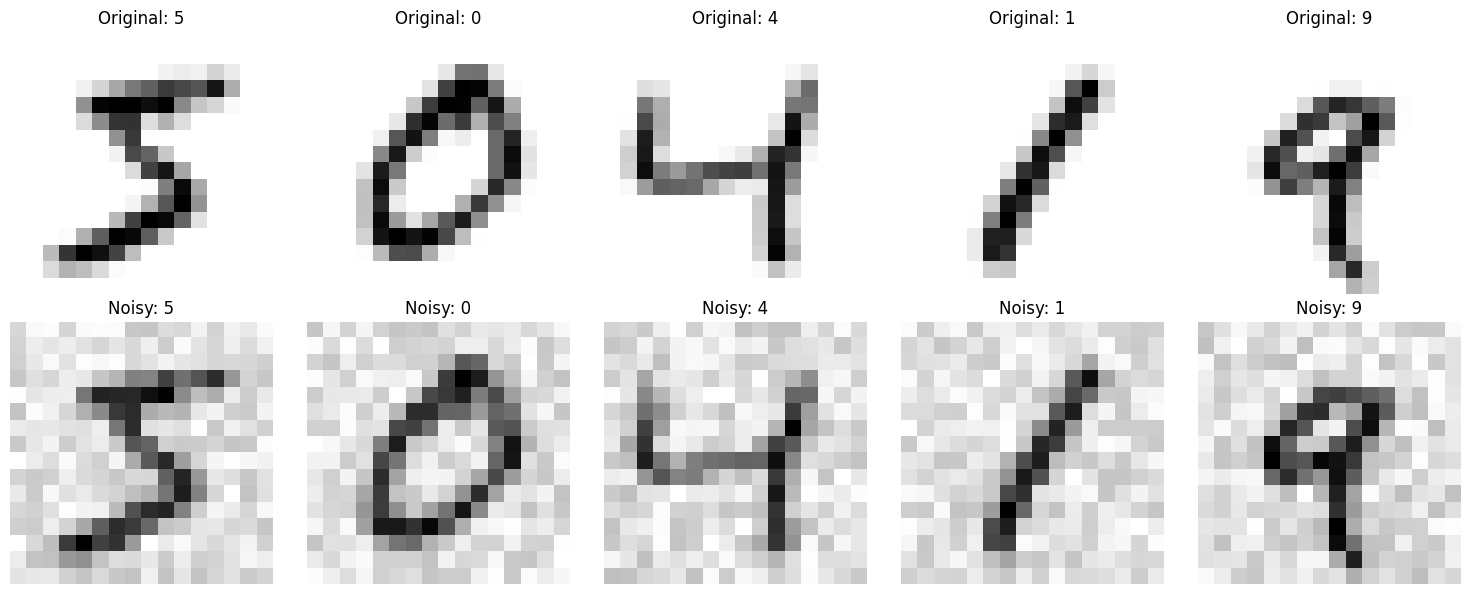

Epoch 1, Batch 100: Loss 0.484
Epoch 1, Batch 200: Loss 0.265
Epoch 1, Batch 300: Loss 0.201
Epoch 1, Batch 400: Loss 0.183
Epoch 1, Batch 500: Loss 0.166
Epoch 1, Batch 600: Loss 0.148
Epoch 1, Batch 700: Loss 0.140
Epoch 1, Batch 800: Loss 0.125
Epoch 1, Batch 900: Loss 0.127
Epoch 1 Test Accuracy: 97.05%
Epoch 2, Batch 100: Loss 0.125
Epoch 2, Batch 200: Loss 0.130
Epoch 2, Batch 300: Loss 0.110
Epoch 2, Batch 400: Loss 0.108
Epoch 2, Batch 500: Loss 0.110
Epoch 2, Batch 600: Loss 0.109
Epoch 2, Batch 700: Loss 0.099
Epoch 2, Batch 800: Loss 0.106
Epoch 2, Batch 900: Loss 0.102
Epoch 2 Test Accuracy: 97.74%
Epoch 3, Batch 100: Loss 0.099
Epoch 3, Batch 200: Loss 0.090
Epoch 3, Batch 300: Loss 0.085
Epoch 3, Batch 400: Loss 0.079
Epoch 3, Batch 500: Loss 0.089
Epoch 3, Batch 600: Loss 0.088
Epoch 3, Batch 700: Loss 0.086
Epoch 3, Batch 800: Loss 0.073
Epoch 3, Batch 900: Loss 0.093
Epoch 3 Test Accuracy: 97.99%
Epoch 4, Batch 100: Loss 0.085
Epoch 4, Batch 200: Loss 0.078
Epoch 4, Ba

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import os
import numpy as np
import matplotlib.pyplot as plt
from mnist_skeptic_v9 import skeptic_v9

# Ensemble Model Creation (keep this part unchanged)
class EnsembleModel(nn.Module):
    def __init__(self, model_paths):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList([skeptic_v9() for _ in range(len(model_paths))])
        for model, path in zip(self.models, model_paths):
            model.load_state_dict(torch.load(path))
            model.eval()

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.stack(outputs).mean(dim=0)

def create_ensemble(model_dir='best_boi_models'):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith('.pth')]
    return EnsembleModel(model_paths)

# Noisy MNIST Dataset
class NoisyMNIST(Dataset):
    def __init__(self, mnist_dataset, noise_factor=0.5):
        self.mnist_dataset = mnist_dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Generate white noise
        noise = torch.rand_like(image)
        # Merge the original image with noise
        noisy_image = (1 - self.noise_factor) * image + self.noise_factor * noise
        return noisy_image, label

# Weighted Loss Function
class WeightedLoss(nn.Module):
    def __init__(self, weight_8=2.0):
        super(WeightedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')
        self.weight_8 = weight_8

    def forward(self, outputs, targets):
        loss = self.ce_loss(outputs, targets)
        weight = torch.ones_like(targets, dtype=torch.float)
        weight[targets == 8] = self.weight_8
        return (loss * weight).mean()

# Data Loading with Weighted Sampler
def load_noisy_mnist_data(batch_size=64, noise_factor=0.5):
    transform = transforms.Compose([
        transforms.Resize((16, 16), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: 1 - x),  # Invert colors
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    
    noisy_train_dataset = NoisyMNIST(train_dataset, noise_factor)
    noisy_test_dataset = NoisyMNIST(test_dataset, noise_factor)
    
    # Create weighted sampler
    train_labels = [label for _, label in train_dataset]
    class_counts = np.bincount(train_labels)
    class_weights = 1. / class_counts
    class_weights[8] = class_weights[8] * 0.5  # Reduce the weight for digit 8
    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    train_loader = DataLoader(noisy_train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Function to display noisy image samples (keep this unchanged)
def display_noisy_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    for i in range(num_samples):
        original_image, _ = dataset.mnist_dataset[i]
        noisy_image, label = dataset[i]
        
        axes[0, i].imshow(original_image.squeeze(), cmap='gray')
        axes[0, i].set_title(f"Original: {label}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(noisy_image.squeeze(), cmap='gray')
        axes[1, i].set_title(f"Noisy: {label}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Fine-tuning function
def fine_tune_model(model, train_loader, test_loader, num_epochs=5, learning_rate=0.0001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = WeightedLoss(weight_8=2.0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % 100 == 99:
                print(f'Epoch {epoch+1}, Batch {i+1}: Loss {running_loss/100:.3f}')
                running_loss = 0.0
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1} Test Accuracy: {accuracy:.2f}%')
    
    return model

# Main function
def main():
    # Load the ensemble model
    ensemble_model = create_ensemble()
    
    # Load noisy MNIST data
    noise_factor = 0.5  # You can adjust this value
    train_loader, test_loader = load_noisy_mnist_data(noise_factor=noise_factor)
    
    # Display noisy image samples
    print("Displaying noisy image samples:")
    display_noisy_samples(train_loader.dataset)
    
    # Ask user if they want to proceed with training
    proceed = input("Do you want to proceed with training? (yes/no): ").lower()
    if proceed != 'yes':
        print("Training aborted.")
        return
    
    # Fine-tune the model
    fine_tuned_model = fine_tune_model(ensemble_model, train_loader, test_loader)
    
    # Save the fine-tuned model
    save_dir = 'best_boi_models_finetuned_standard'
    os.makedirs(save_dir, exist_ok=True)
    torch.save(fine_tuned_model.state_dict(), os.path.join(save_dir, f'ensemble_finetuned_noisy_mnist_balanced_{noise_factor}.pth'))
    print(f"Fine-tuned model saved in {save_dir}")

if __name__ == "__main__":
    main()